In [880]:
#!pip install scikit-learn

In [881]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy

In [882]:
#!pip install tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score,mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
#definindo o dataser
dataframe = pd.read_csv('./DF/dadosTREINO1_1_label.csv', header=None) 
#dataframe = dataframe.drop([0], axis =0)
raw_data = dataframe.values


In [3]:


labels = raw_data[1:, -1] #classe: utlima coluna

data = raw_data[1:, 0:50] #previsores

#definindo os dados de treino e de teste
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.25, random_state=21
)

In [4]:
#faz a normalização
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels] #dados sem covid: classe = 0
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels] #dados com covid: classe = 1 
anomalous_test_data = test_data[test_labels]

In [6]:
#definição das camadas do autoencoder
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        
      # 32 16 8 16 32 50   
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(50, activation="sigmoid")]) #esse valor não pode ser maior que a quantidade de pontos de teste (features)

  def call(self, x):
    encoded = self.encoder(x) #codifica
    decoded = self.decoder(encoded) #decodifica o encoder
    return decoded

autoencoder = AnomalyDetector()

In [890]:
print(train_data.shape)

(84, 50)


In [7]:
def soft_dice_loss(y_true, y_pred):

    axis=[0]
    epsilon=0.00001
    dice_numerator = 2*tf.keras.backend.sum(y_true*y_pred,axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_pred*y_pred)+ tf.keras.backend.sum(y_true*y_true)+ epsilon
    dice_loss = 1-tf.keras.backend.mean(dice_numerator/dice_denominator)

    return dice_loss
def single_class_dice_coefficient(y_true, y_pred, axis=(0), epsilon=0.00001):
  
    axis=[0]
    epsilon=0.00001
    dice_numerator = 2*tf.keras.backend.sum(y_true*y_pred,axis=axis)+epsilon
    dice_denominator = tf.keras.backend.sum(y_true,axis=axis)+ tf.keras.backend.sum(y_pred,axis=axis) + epsilon
    dice_coefficient = tf.keras.backend.mean(dice_numerator/dice_denominator)

    return dice_coefficient

In [8]:
#gera o modelo
autoencoder.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.AUC(from_logits=True),'accuracy',single_class_dice_coefficient, soft_dice_loss])
#autoencoder.summary()

In [9]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('modelegmentation.h5', monitor='single_class_dice_coefficient', verbose=1,save_best_only=True, mode='max')
callbacks=[checkpointer, tf.keras.callbacks.EarlyStopping(patience=2, monitor='single_class_dice_coefficient', mode='max'),tf.keras.callbacks.TensorBoard(log_dir='logs2')]

In [14]:
#treina o modelo
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=3000, 
          batch_size=4,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/3000
13/13 [==============================] - 0s 5ms/step - loss: 0.0230 - recall: 0.3519 - auc: 0.9973 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4896 - soft_dice_loss: 0.9801 - val_loss: 0.0349 - val_recall: 0.3455 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5052 - val_soft_dice_loss: 0.9802
Epoch 2/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0233 - recall: 0.3617 - auc: 0.9969 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4808 - soft_dice_loss: 0.9801 - val_loss: 0.0359 - val_recall: 0.3455 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5079 - val_soft_dice_loss: 0.9802
Epoch 3/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0235 - recall: 0.3554 - auc: 0.9969 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4736 - soft_dice_loss: 0.9801 - val_loss: 0.0358 - val_recall: 0.3455 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_singl

13/13 [==============================] - 0s 4ms/step - loss: 0.0228 - recall: 0.3617 - auc: 0.9969 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4860 - soft_dice_loss: 0.9801 - val_loss: 0.0351 - val_recall: 0.3448 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9802
Epoch 25/3000
13/13 [==============================] - 0s 4ms/step - loss: 0.0229 - recall: 0.3452 - auc: 0.9974 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4807 - soft_dice_loss: 0.9801 - val_loss: 0.0362 - val_recall: 0.3448 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5014 - val_soft_dice_loss: 0.9802
Epoch 26/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0234 - recall: 0.3590 - auc: 0.9971 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4830 - soft_dice_loss: 0.9801 - val_loss: 0.0353 - val_recall: 0.3462 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dic

13/13 [==============================] - 0s 3ms/step - loss: 0.0234 - recall: 0.3405 - auc: 0.9969 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4948 - soft_dice_loss: 0.9801 - val_loss: 0.0375 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5114 - val_soft_dice_loss: 0.9802
Epoch 48/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0229 - recall: 0.3629 - auc: 0.9965 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4888 - soft_dice_loss: 0.9801 - val_loss: 0.0352 - val_recall: 0.3462 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9802
Epoch 49/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0231 - recall: 0.3488 - auc: 0.9886 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4856 - soft_dice_loss: 0.9801 - val_loss: 0.0364 - val_recall: 0.3524 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dic

13/13 [==============================] - 0s 3ms/step - loss: 0.0223 - recall: 0.3472 - auc: 0.9869 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4879 - soft_dice_loss: 0.9801 - val_loss: 0.0348 - val_recall: 0.3476 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9802
Epoch 71/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0222 - recall: 0.3641 - auc: 0.9965 - accuracy: 0.0392 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9801 - val_loss: 0.0343 - val_recall: 0.3448 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5048 - val_soft_dice_loss: 0.9802
Epoch 72/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0226 - recall: 0.3656 - auc: 0.9965 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4898 - soft_dice_loss: 0.9801 - val_loss: 0.0347 - val_recall: 0.3448 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dic

13/13 [==============================] - 0s 2ms/step - loss: 0.0230 - recall: 0.3652 - auc: 0.9963 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4957 - soft_dice_loss: 0.9801 - val_loss: 0.0353 - val_recall: 0.3448 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5030 - val_soft_dice_loss: 0.9802
Epoch 94/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0227 - recall: 0.3382 - auc: 0.9880 - accuracy: 0.0980 - single_class_dice_coefficient: 0.4881 - soft_dice_loss: 0.9801 - val_loss: 0.0352 - val_recall: 0.3476 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5075 - val_soft_dice_loss: 0.9802
Epoch 95/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0225 - recall: 0.3468 - auc: 0.9867 - accuracy: 0.0588 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9801 - val_loss: 0.0360 - val_recall: 0.3538 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class

13/13 [==============================] - 0s 3ms/step - loss: 0.0221 - recall: 0.3590 - auc: 0.9876 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4800 - soft_dice_loss: 0.9801 - val_loss: 0.0344 - val_recall: 0.3469 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5043 - val_soft_dice_loss: 0.9802
Epoch 117/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0216 - recall: 0.3609 - auc: 0.9853 - accuracy: 0.0980 - single_class_dice_coefficient: 0.4821 - soft_dice_loss: 0.9801 - val_loss: 0.0338 - val_recall: 0.3469 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5051 - val_soft_dice_loss: 0.9802
Epoch 118/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0221 - recall: 0.3578 - auc: 0.9874 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4700 - soft_dice_loss: 0.9801 - val_loss: 0.0343 - val_recall: 0.3455 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 2ms/step - loss: 0.0213 - recall: 0.3574 - auc: 0.9869 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4850 - soft_dice_loss: 0.9801 - val_loss: 0.0338 - val_recall: 0.3503 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5045 - val_soft_dice_loss: 0.9802
Epoch 140/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0213 - recall: 0.3468 - auc: 0.9872 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4944 - soft_dice_loss: 0.9801 - val_loss: 0.0344 - val_recall: 0.3517 - val_auc: 0.0000e+00 - val_accuracy: 0.1034 - val_single_class_dice_coefficient: 0.5073 - val_soft_dice_loss: 0.9802
Epoch 141/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0212 - recall: 0.3503 - auc: 0.9955 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4869 - soft_dice_loss: 0.9801 - val_loss: 0.0338 - val_recall: 0.3524 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0214 - recall: 0.3554 - auc: 0.9871 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4985 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3517 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5052 - val_soft_dice_loss: 0.9802
Epoch 163/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0213 - recall: 0.3758 - auc: 0.9957 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4754 - soft_dice_loss: 0.9801 - val_loss: 0.0337 - val_recall: 0.3517 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5048 - val_soft_dice_loss: 0.9802
Epoch 164/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0208 - recall: 0.3546 - auc: 0.9863 - accuracy: 0.0980 - single_class_dice_coefficient: 0.4946 - soft_dice_loss: 0.9801 - val_loss: 0.0340 - val_recall: 0.3531 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0220 - recall: 0.3633 - auc: 0.9857 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4716 - soft_dice_loss: 0.9801 - val_loss: 0.0352 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5110 - val_soft_dice_loss: 0.9802
Epoch 186/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0213 - recall: 0.3621 - auc: 0.9865 - accuracy: 0.0784 - single_class_dice_coefficient: 0.4876 - soft_dice_loss: 0.9801 - val_loss: 0.0340 - val_recall: 0.3552 - val_auc: 0.0000e+00 - val_accuracy: 0.1034 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9802
Epoch 187/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0210 - recall: 0.3711 - auc: 0.9955 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4792 - soft_dice_loss: 0.9801 - val_loss: 0.0347 - val_recall: 0.3510 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0198 - recall: 0.3625 - auc: 0.9959 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4722 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3552 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9801
Epoch 209/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0202 - recall: 0.3617 - auc: 0.9861 - accuracy: 0.0980 - single_class_dice_coefficient: 0.4795 - soft_dice_loss: 0.9801 - val_loss: 0.0348 - val_recall: 0.3510 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5016 - val_soft_dice_loss: 0.9802
Epoch 210/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0210 - recall: 0.3515 - auc: 0.9959 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4877 - soft_dice_loss: 0.9800 - val_loss: 0.0346 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0202 - recall: 0.3731 - auc: 0.9859 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4895 - soft_dice_loss: 0.9800 - val_loss: 0.0362 - val_recall: 0.3717 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5132 - val_soft_dice_loss: 0.9801
Epoch 232/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0214 - recall: 0.3374 - auc: 0.9880 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4814 - soft_dice_loss: 0.9801 - val_loss: 0.0332 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 233/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0210 - recall: 0.3413 - auc: 0.9961 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4852 - soft_dice_loss: 0.9800 - val_loss: 0.0338 - val_recall: 0.3545 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0195 - recall: 0.3578 - auc: 0.9871 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4857 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 255/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0193 - recall: 0.3558 - auc: 0.9851 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4890 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5096 - val_soft_dice_loss: 0.9801
Epoch 256/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0196 - recall: 0.3684 - auc: 0.9855 - accuracy: 0.0980 - single_class_dice_coefficient: 0.4915 - soft_dice_loss: 0.9800 - val_loss: 0.0341 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0206 - recall: 0.3519 - auc: 0.9865 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4808 - soft_dice_loss: 0.9801 - val_loss: 0.0342 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 278/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0198 - recall: 0.3723 - auc: 0.9953 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4791 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5076 - val_soft_dice_loss: 0.9801
Epoch 279/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0192 - recall: 0.3535 - auc: 0.9859 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4858 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0201 - recall: 0.3758 - auc: 0.9861 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4839 - soft_dice_loss: 0.9800 - val_loss: 0.0352 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5123 - val_soft_dice_loss: 0.9801
Epoch 301/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0191 - recall: 0.3578 - auc: 0.9845 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4918 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 302/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0197 - recall: 0.3648 - auc: 0.9859 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4748 - soft_dice_loss: 0.9800 - val_loss: 0.0350 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

Epoch 323/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0186 - recall: 0.3535 - auc: 0.9869 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4950 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5102 - val_soft_dice_loss: 0.9801
Epoch 324/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0186 - recall: 0.3562 - auc: 0.9947 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4921 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 325/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0192 - recall: 0.3566 - auc: 0.9847 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4773 - soft_dice_loss: 0.9800 - val_loss: 0.0350 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

13/13 [==============================] - 0s 3ms/step - loss: 0.0187 - recall: 0.3578 - auc: 0.9863 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4889 - soft_dice_loss: 0.9800 - val_loss: 0.0351 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5114 - val_soft_dice_loss: 0.9801
Epoch 347/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0188 - recall: 0.3731 - auc: 0.9951 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4801 - soft_dice_loss: 0.9800 - val_loss: 0.0361 - val_recall: 0.3786 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5128 - val_soft_dice_loss: 0.9801
Epoch 348/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0204 - recall: 0.3986 - auc: 0.9953 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4774 - soft_dice_loss: 0.9800 - val_loss: 0.0348 - val_recall: 0.3552 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0181 - recall: 0.3550 - auc: 0.9857 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4900 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 370/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0180 - recall: 0.3546 - auc: 0.9867 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4881 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9801
Epoch 371/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0185 - recall: 0.3586 - auc: 0.9953 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4830 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0179 - recall: 0.3554 - auc: 0.9951 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4945 - soft_dice_loss: 0.9800 - val_loss: 0.0346 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5106 - val_soft_dice_loss: 0.9801
Epoch 393/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0202 - recall: 0.3397 - auc: 0.9865 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4800 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3717 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5083 - val_soft_dice_loss: 0.9801
Epoch 394/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0206 - recall: 0.3860 - auc: 0.9949 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4883 - soft_dice_loss: 0.9800 - val_loss: 0.0346 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 2ms/step - loss: 0.0179 - recall: 0.3578 - auc: 0.9949 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4959 - soft_dice_loss: 0.9800 - val_loss: 0.0341 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5095 - val_soft_dice_loss: 0.9801
Epoch 416/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0183 - recall: 0.3731 - auc: 0.9863 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4793 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 417/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0183 - recall: 0.3586 - auc: 0.9951 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4768 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0188 - recall: 0.3656 - auc: 0.9865 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4851 - soft_dice_loss: 0.9800 - val_loss: 0.0338 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 439/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0176 - recall: 0.3543 - auc: 0.9949 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4916 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5091 - val_soft_dice_loss: 0.9801
Epoch 440/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0175 - recall: 0.3613 - auc: 0.9949 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4865 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0203 - recall: 0.3845 - auc: 0.9945 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4890 - soft_dice_loss: 0.9800 - val_loss: 0.0376 - val_recall: 0.3828 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5160 - val_soft_dice_loss: 0.9801
Epoch 462/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0197 - recall: 0.3829 - auc: 0.9941 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4970 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5066 - val_soft_dice_loss: 0.9801
Epoch 463/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0182 - recall: 0.3515 - auc: 0.9882 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4885 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0173 - recall: 0.3554 - auc: 0.9947 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4915 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 485/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0176 - recall: 0.3590 - auc: 0.9949 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4790 - soft_dice_loss: 0.9800 - val_loss: 0.0344 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5112 - val_soft_dice_loss: 0.9801
Epoch 486/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0174 - recall: 0.3656 - auc: 0.9947 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4890 - soft_dice_loss: 0.9800 - val_loss: 0.0341 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0170 - recall: 0.3613 - auc: 0.9947 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4835 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5092 - val_soft_dice_loss: 0.9801
Epoch 508/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0174 - recall: 0.3621 - auc: 0.9947 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4819 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 509/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0172 - recall: 0.3645 - auc: 0.9947 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0167 - recall: 0.3539 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4848 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 531/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0168 - recall: 0.3476 - auc: 0.9947 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4852 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 532/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0177 - recall: 0.3633 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4884 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_cla

13/13 [==============================] - 0s 4ms/step - loss: 0.0174 - recall: 0.3562 - auc: 0.9947 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4819 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5064 - val_soft_dice_loss: 0.9801
Epoch 554/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0179 - recall: 0.3594 - auc: 0.9951 - accuracy: 0.2157 - single_class_dice_coefficient: 0.5000 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3572 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 555/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0167 - recall: 0.3503 - auc: 0.9947 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4749 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

Epoch 576/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - recall: 0.3707 - auc: 0.9947 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4791 - soft_dice_loss: 0.9800 - val_loss: 0.0348 - val_recall: 0.3559 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5052 - val_soft_dice_loss: 0.9801
Epoch 577/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0177 - recall: 0.3629 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3531 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5036 - val_soft_dice_loss: 0.9801
Epoch 578/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0178 - recall: 0.3660 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4786 - soft_dice_loss: 0.9800 - val_loss: 0.0348 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val

13/13 [==============================] - 0s 3ms/step - loss: 0.0170 - recall: 0.3621 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4910 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3559 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5053 - val_soft_dice_loss: 0.9801
Epoch 600/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0163 - recall: 0.3550 - auc: 0.9947 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4873 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 601/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0167 - recall: 0.3668 - auc: 0.9945 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4833 - soft_dice_loss: 0.9800 - val_loss: 0.0345 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

13/13 [==============================] - 0s 3ms/step - loss: 0.0160 - recall: 0.3582 - auc: 0.9947 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4843 - soft_dice_loss: 0.9800 - val_loss: 0.0348 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5119 - val_soft_dice_loss: 0.9801
Epoch 623/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - recall: 0.3546 - auc: 0.9947 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4834 - soft_dice_loss: 0.9800 - val_loss: 0.0351 - val_recall: 0.3766 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5117 - val_soft_dice_loss: 0.9801
Epoch 624/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - recall: 0.3688 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4867 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

Epoch 645/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0160 - recall: 0.3566 - auc: 0.9943 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4899 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 646/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0160 - recall: 0.3633 - auc: 0.9947 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4884 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 647/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0164 - recall: 0.3743 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4935 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 -

Epoch 668/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0170 - recall: 0.3621 - auc: 0.9945 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4867 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5057 - val_soft_dice_loss: 0.9801
Epoch 669/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - recall: 0.3660 - auc: 0.9947 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4875 - soft_dice_loss: 0.9800 - val_loss: 0.0349 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5111 - val_soft_dice_loss: 0.9801
Epoch 670/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0161 - recall: 0.3723 - auc: 0.9943 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4961 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+

Epoch 691/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0161 - recall: 0.3719 - auc: 0.9939 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4823 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5079 - val_soft_dice_loss: 0.9801
Epoch 692/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0155 - recall: 0.3621 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4717 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5083 - val_soft_dice_loss: 0.9801
Epoch 693/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0157 - recall: 0.3558 - auc: 0.9947 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4950 - soft_dice_loss: 0.9800 - val_loss: 0.0338 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 714/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0154 - recall: 0.3660 - auc: 0.9947 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4853 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5095 - val_soft_dice_loss: 0.9801
Epoch 715/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0152 - recall: 0.3566 - auc: 0.9945 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4897 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9801
Epoch 716/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0161 - recall: 0.3586 - auc: 0.9943 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4769 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 737/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0161 - recall: 0.3488 - auc: 0.9947 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5084 - val_soft_dice_loss: 0.9801
Epoch 738/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0162 - recall: 0.3801 - auc: 0.9943 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4991 - soft_dice_loss: 0.9800 - val_loss: 0.0346 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5114 - val_soft_dice_loss: 0.9801
Epoch 739/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0162 - recall: 0.3546 - auc: 0.9947 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4927 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 -

Epoch 760/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0149 - recall: 0.3546 - auc: 0.9943 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4910 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 761/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0155 - recall: 0.3578 - auc: 0.9945 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4816 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5084 - val_soft_dice_loss: 0.9801
Epoch 762/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0154 - recall: 0.3582 - auc: 0.9943 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4830 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val

Epoch 783/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0160 - recall: 0.3468 - auc: 0.9945 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4997 - soft_dice_loss: 0.9800 - val_loss: 0.0353 - val_recall: 0.3724 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5127 - val_soft_dice_loss: 0.9801
Epoch 784/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0165 - recall: 0.3696 - auc: 0.9941 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4786 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3552 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5046 - val_soft_dice_loss: 0.9801
Epoch 785/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0175 - recall: 0.3472 - auc: 0.9947 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4721 - soft_dice_loss: 0.9800 - val_loss: 0.0362 - val_recall: 0.3793 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 -

13/13 [==============================] - 0s 3ms/step - loss: 0.0149 - recall: 0.3543 - auc: 0.9943 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4982 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5088 - val_soft_dice_loss: 0.9801
Epoch 807/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0154 - recall: 0.3605 - auc: 0.9943 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4806 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 808/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0158 - recall: 0.3507 - auc: 0.9945 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4784 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_d

Epoch 829/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0175 - recall: 0.3743 - auc: 0.9973 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4841 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 830/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0175 - recall: 0.3664 - auc: 0.9947 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4937 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5024 - val_soft_dice_loss: 0.9801
Epoch 831/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0164 - recall: 0.3550 - auc: 0.9943 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4927 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 852/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0145 - recall: 0.3578 - auc: 0.9943 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4854 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5097 - val_soft_dice_loss: 0.9801
Epoch 853/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0144 - recall: 0.3633 - auc: 0.9941 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4887 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 854/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0145 - recall: 0.3633 - auc: 0.9941 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4802 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 875/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0159 - recall: 0.3648 - auc: 0.9943 - accuracy: 0.1176 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 876/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0153 - recall: 0.3637 - auc: 0.9937 - accuracy: 0.1373 - single_class_dice_coefficient: 0.4759 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5100 - val_soft_dice_loss: 0.9801
Epoch 877/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0148 - recall: 0.3703 - auc: 0.9935 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4840 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 -

Epoch 898/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0147 - recall: 0.3613 - auc: 0.9937 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4882 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 899/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0148 - recall: 0.3566 - auc: 0.9949 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5111 - val_soft_dice_loss: 0.9801
Epoch 900/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0148 - recall: 0.3578 - auc: 0.9973 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4885 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 921/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0143 - recall: 0.3562 - auc: 0.9937 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4874 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5075 - val_soft_dice_loss: 0.9801
Epoch 922/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - recall: 0.3629 - auc: 0.9941 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4845 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5104 - val_soft_dice_loss: 0.9801
Epoch 923/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - recall: 0.3609 - auc: 0.9973 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4881 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 944/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - recall: 0.3566 - auc: 0.9969 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4871 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5104 - val_soft_dice_loss: 0.9801
Epoch 945/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0145 - recall: 0.3566 - auc: 0.9945 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5081 - val_soft_dice_loss: 0.9801
Epoch 946/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0145 - recall: 0.3535 - auc: 0.9973 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4947 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.00

Epoch 967/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0144 - recall: 0.3715 - auc: 0.9973 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4857 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5123 - val_soft_dice_loss: 0.9801
Epoch 968/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0144 - recall: 0.3648 - auc: 0.9973 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4812 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5090 - val_soft_dice_loss: 0.9801
Epoch 969/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0155 - recall: 0.3805 - auc: 0.9973 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4968 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 -

Epoch 990/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3594 - auc: 0.9937 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4791 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5102 - val_soft_dice_loss: 0.9801
Epoch 991/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0144 - recall: 0.3617 - auc: 0.9971 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4891 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 992/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - recall: 0.3597 - auc: 0.9971 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4878 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val

Epoch 1013/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0138 - recall: 0.3531 - auc: 0.9971 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4887 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5117 - val_soft_dice_loss: 0.9801
Epoch 1014/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0150 - recall: 0.3550 - auc: 0.9971 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4898 - soft_dice_loss: 0.9800 - val_loss: 0.0322 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 1015/3000
13/13 [==============================] - 0s 1ms/step - loss: 0.0150 - recall: 0.3801 - auc: 0.9971 - accuracy: 0.1569 - single_class_dice_coefficient: 0.4898 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1036/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0151 - recall: 0.3625 - auc: 0.9971 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4962 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5093 - val_soft_dice_loss: 0.9801
Epoch 1037/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0147 - recall: 0.3590 - auc: 0.9971 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4759 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5128 - val_soft_dice_loss: 0.9801
Epoch 1038/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0144 - recall: 0.3688 - auc: 0.9971 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4904 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3572 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1059/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0199 - recall: 0.3550 - auc: 0.9971 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4735 - soft_dice_loss: 0.9800 - val_loss: 0.0362 - val_recall: 0.3821 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5130 - val_soft_dice_loss: 0.9801
Epoch 1060/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0192 - recall: 0.3676 - auc: 0.9957 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4659 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5058 - val_soft_dice_loss: 0.9801
Epoch 1061/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0154 - recall: 0.3554 - auc: 0.9971 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4872 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 1082/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137 - recall: 0.3562 - auc: 0.9971 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4872 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 1083/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134 - recall: 0.3676 - auc: 0.9971 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4821 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5088 - val_soft_dice_loss: 0.9801
Epoch 1084/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137 - recall: 0.3621 - auc: 0.9971 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4939 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1105/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0133 - recall: 0.3609 - auc: 0.9967 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4920 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5081 - val_soft_dice_loss: 0.9801
Epoch 1106/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3625 - auc: 0.9971 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4778 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 1107/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137 - recall: 0.3637 - auc: 0.9971 - accuracy: 0.1961 - single_class_dice_coefficient: 0.4965 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 1128/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0138 - recall: 0.3645 - auc: 0.9969 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4823 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5091 - val_soft_dice_loss: 0.9801
Epoch 1129/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0139 - recall: 0.3566 - auc: 0.9973 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4723 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5054 - val_soft_dice_loss: 0.9801
Epoch 1130/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0157 - recall: 0.3480 - auc: 0.9971 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4817 - soft_dice_loss: 0.9800 - val_loss: 0.0352 - val_recall: 0.3772 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1151/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3543 - auc: 0.9969 - accuracy: 0.1765 - single_class_dice_coefficient: 0.4948 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5109 - val_soft_dice_loss: 0.9801
Epoch 1152/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0142 - recall: 0.3613 - auc: 0.9971 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 1153/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0134 - recall: 0.3633 - auc: 0.9971 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4840 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1174/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3637 - auc: 0.9961 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 1175/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0132 - recall: 0.3519 - auc: 0.9971 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4955 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5121 - val_soft_dice_loss: 0.9801
Epoch 1176/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0144 - recall: 0.3527 - auc: 0.9971 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4920 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1197/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3570 - auc: 0.9965 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4907 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 1198/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0144 - recall: 0.3645 - auc: 0.9967 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4868 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5097 - val_soft_dice_loss: 0.9801
Epoch 1199/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3515 - auc: 0.9971 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4876 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1220/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0138 - recall: 0.3570 - auc: 0.9971 - accuracy: 0.2157 - single_class_dice_coefficient: 0.4817 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5113 - val_soft_dice_loss: 0.9801
Epoch 1221/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0138 - recall: 0.3684 - auc: 0.9967 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4738 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5106 - val_soft_dice_loss: 0.9801
Epoch 1222/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0139 - recall: 0.3692 - auc: 0.9969 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4888 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 1243/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0133 - recall: 0.3637 - auc: 0.9971 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4854 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 1244/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134 - recall: 0.3539 - auc: 0.9965 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4920 - soft_dice_loss: 0.9800 - val_loss: 0.0346 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5127 - val_soft_dice_loss: 0.9801
Epoch 1245/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - recall: 0.3676 - auc: 0.9967 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4866 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1266/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3633 - auc: 0.9967 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4848 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5079 - val_soft_dice_loss: 0.9801
Epoch 1267/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3645 - auc: 0.9963 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4865 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5088 - val_soft_dice_loss: 0.9801
Epoch 1268/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3605 - auc: 0.9969 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4796 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3724 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1289/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3554 - auc: 0.9967 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4908 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5107 - val_soft_dice_loss: 0.9801
Epoch 1290/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0135 - recall: 0.3672 - auc: 0.9965 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4844 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9801
Epoch 1291/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0139 - recall: 0.3723 - auc: 0.9967 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4907 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1312/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0140 - recall: 0.3523 - auc: 0.9969 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4807 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5110 - val_soft_dice_loss: 0.9801
Epoch 1313/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134 - recall: 0.3652 - auc: 0.9969 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4876 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 1314/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0139 - recall: 0.3629 - auc: 0.9963 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4811 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1335/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137 - recall: 0.3707 - auc: 0.9967 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4943 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5086 - val_soft_dice_loss: 0.9801
Epoch 1336/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3613 - auc: 0.9967 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4781 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5096 - val_soft_dice_loss: 0.9801
Epoch 1337/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0133 - recall: 0.3637 - auc: 0.9965 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4790 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1358/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0132 - recall: 0.3609 - auc: 0.9965 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4917 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5109 - val_soft_dice_loss: 0.9801
Epoch 1359/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0138 - recall: 0.3495 - auc: 0.9965 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4830 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5107 - val_soft_dice_loss: 0.9801
Epoch 1360/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0135 - recall: 0.3723 - auc: 0.9965 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4844 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1381/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0152 - recall: 0.3719 - auc: 0.9963 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4766 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 1382/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3590 - auc: 0.9967 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4880 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5104 - val_soft_dice_loss: 0.9801
Epoch 1383/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3688 - auc: 0.9967 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4925 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1404/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3637 - auc: 0.9963 - accuracy: 0.2353 - single_class_dice_coefficient: 0.4942 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5094 - val_soft_dice_loss: 0.9801
Epoch 1405/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3656 - auc: 0.9963 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4819 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5087 - val_soft_dice_loss: 0.9801
Epoch 1406/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0131 - recall: 0.3511 - auc: 0.9965 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1427/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0135 - recall: 0.3668 - auc: 0.9963 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 1428/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3711 - auc: 0.9963 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4838 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 1429/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0126 - recall: 0.3590 - auc: 0.9963 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4961 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1450/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3699 - auc: 0.9963 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4945 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 1451/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0135 - recall: 0.3543 - auc: 0.9965 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4872 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5091 - val_soft_dice_loss: 0.9801
Epoch 1452/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3629 - auc: 0.9963 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4881 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1473/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127 - recall: 0.3566 - auc: 0.9963 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4867 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5102 - val_soft_dice_loss: 0.9801
Epoch 1474/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3566 - auc: 0.9963 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4934 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5100 - val_soft_dice_loss: 0.9801
Epoch 1475/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0125 - recall: 0.3656 - auc: 0.9961 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1496/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4924 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5096 - val_soft_dice_loss: 0.9801
Epoch 1497/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0128 - recall: 0.3590 - auc: 0.9961 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4847 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 1498/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4745 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - 

Epoch 1519/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3629 - auc: 0.9963 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4866 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 1520/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0126 - recall: 0.3594 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4773 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5086 - val_soft_dice_loss: 0.9801
Epoch 1521/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0128 - recall: 0.3582 - auc: 0.9988 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4851 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1542/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3648 - auc: 0.9961 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4934 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3731 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5121 - val_soft_dice_loss: 0.9801
Epoch 1543/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4912 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5097 - val_soft_dice_loss: 0.9801
Epoch 1544/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0131 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4929 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 1565/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134 - recall: 0.3535 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4820 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 1566/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0145 - recall: 0.3680 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4857 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5052 - val_soft_dice_loss: 0.9801
Epoch 1567/3000
13/13 [==============================] - 0s 4ms/step - loss: 0.0142 - recall: 0.3692 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4877 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3717 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1588/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0122 - recall: 0.3507 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4861 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5091 - val_soft_dice_loss: 0.9801
Epoch 1589/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3582 - auc: 0.9988 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4897 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9801
Epoch 1590/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3696 - auc: 0.9986 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4847 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3717 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1611/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0125 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4706 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5113 - val_soft_dice_loss: 0.9801
Epoch 1612/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3550 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4896 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 1613/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3660 - auc: 0.9986 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1634/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3707 - auc: 0.9988 - accuracy: 0.2549 - single_class_dice_coefficient: 0.4884 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5064 - val_soft_dice_loss: 0.9801
Epoch 1635/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3503 - auc: 0.9988 - accuracy: 0.2745 - single_class_dice_coefficient: 0.4876 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5109 - val_soft_dice_loss: 0.9801
Epoch 1636/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0124 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4933 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1657/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134 - recall: 0.3492 - auc: 0.9986 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4860 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3752 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5113 - val_soft_dice_loss: 0.9801
Epoch 1658/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3586 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4869 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9801
Epoch 1659/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127 - recall: 0.3711 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4945 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1680/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3648 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4897 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5114 - val_soft_dice_loss: 0.9801
Epoch 1681/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3676 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4887 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 1682/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4987 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1703/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3762 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4842 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5057 - val_soft_dice_loss: 0.9801
Epoch 1704/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3597 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4854 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3752 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5120 - val_soft_dice_loss: 0.9801
Epoch 1705/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3688 - auc: 0.9986 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4918 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1726/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0122 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4782 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3703 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5100 - val_soft_dice_loss: 0.9801
Epoch 1727/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3641 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4933 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3710 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 1728/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3539 - auc: 0.9986 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4896 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1749/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0141 - recall: 0.3707 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4960 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5051 - val_soft_dice_loss: 0.9801
Epoch 1750/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0133 - recall: 0.3680 - auc: 0.9986 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4911 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5059 - val_soft_dice_loss: 0.9801
Epoch 1751/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0137 - recall: 0.3609 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4845 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3745 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 1772/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0127 - recall: 0.3594 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4881 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 1773/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129 - recall: 0.3735 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4973 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9801
Epoch 1774/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4845 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1795/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0122 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4963 - soft_dice_loss: 0.9800 - val_loss: 0.0339 - val_recall: 0.3683 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5113 - val_soft_dice_loss: 0.9801
Epoch 1796/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0125 - recall: 0.3515 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4852 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 1797/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0119 - recall: 0.3637 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4871 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1818/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0121 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4887 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5058 - val_soft_dice_loss: 0.9801
Epoch 1819/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0119 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4921 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 1820/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0122 - recall: 0.3727 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4835 - soft_dice_loss: 0.9800 - val_loss: 0.0345 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1841/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0116 - recall: 0.3586 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4949 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5081 - val_soft_dice_loss: 0.9801
Epoch 1842/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0119 - recall: 0.3731 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5060 - val_soft_dice_loss: 0.9801
Epoch 1843/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0125 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4930 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 1864/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3747 - auc: 0.9986 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4909 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5084 - val_soft_dice_loss: 0.9801
Epoch 1865/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4845 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 1866/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4956 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3676 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1887/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4951 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3697 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 1888/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127 - recall: 0.3586 - auc: 0.9986 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4917 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 1889/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3735 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4761 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 1910/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3511 - auc: 0.9986 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4835 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 1911/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0135 - recall: 0.3539 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4965 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5110 - val_soft_dice_loss: 0.9801
Epoch 1912/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3652 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4872 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 1933/3000
13/13 [==============================] - 0s 4ms/step - loss: 0.0124 - recall: 0.3554 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4805 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3690 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5087 - val_soft_dice_loss: 0.9801
Epoch 1934/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3633 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4856 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 1935/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0132 - recall: 0.3852 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4822 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1956/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3605 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4894 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 1957/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4763 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5063 - val_soft_dice_loss: 0.9801
Epoch 1958/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3656 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4912 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 1979/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0119 - recall: 0.3711 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4809 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 1980/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0124 - recall: 0.3613 - auc: 0.9986 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4901 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3572 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5035 - val_soft_dice_loss: 0.9801
Epoch 1981/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0125 - recall: 0.3684 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4897 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2002/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3621 - auc: 0.9986 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4926 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5094 - val_soft_dice_loss: 0.9801
Epoch 2003/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0116 - recall: 0.3621 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4870 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5052 - val_soft_dice_loss: 0.9801
Epoch 2004/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3507 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4829 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2025/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - recall: 0.3633 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4859 - soft_dice_loss: 0.9800 - val_loss: 0.0338 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5040 - val_soft_dice_loss: 0.9801
Epoch 2026/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127 - recall: 0.3723 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4807 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 2027/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3743 - auc: 0.9988 - accuracy: 0.2941 - single_class_dice_coefficient: 0.4919 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2048/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3809 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4827 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5076 - val_soft_dice_loss: 0.9801
Epoch 2049/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4744 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5078 - val_soft_dice_loss: 0.9801
Epoch 2050/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3594 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4843 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2071/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0127 - recall: 0.3680 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4944 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 2072/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3719 - auc: 0.9986 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4975 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5093 - val_soft_dice_loss: 0.9801
Epoch 2073/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0119 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4953 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2094/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0137 - recall: 0.3495 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4774 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5100 - val_soft_dice_loss: 0.9801
Epoch 2095/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0142 - recall: 0.3672 - auc: 0.9986 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4953 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3662 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5102 - val_soft_dice_loss: 0.9801
Epoch 2096/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4784 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2117/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0114 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.3137 - single_class_dice_coefficient: 0.4874 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5110 - val_soft_dice_loss: 0.9801
Epoch 2118/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0112 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4825 - soft_dice_loss: 0.9800 - val_loss: 0.0323 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5073 - val_soft_dice_loss: 0.9801
Epoch 2119/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0111 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4920 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2140/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3543 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4947 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5092 - val_soft_dice_loss: 0.9801
Epoch 2141/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0115 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4958 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 2142/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2163/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - recall: 0.3731 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4822 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5090 - val_soft_dice_loss: 0.9801
Epoch 2164/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0120 - recall: 0.3444 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4983 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5093 - val_soft_dice_loss: 0.9801
Epoch 2165/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3656 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4931 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2186/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0112 - recall: 0.3641 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5070 - val_soft_dice_loss: 0.9801
Epoch 2187/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3652 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4920 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 2188/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - recall: 0.3566 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4943 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.069

Epoch 2209/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4805 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 2210/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3660 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4836 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5058 - val_soft_dice_loss: 0.9801
Epoch 2211/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4927 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2232/3000
13/13 [==============================] - 0s 4ms/step - loss: 0.0118 - recall: 0.3688 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4830 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5112 - val_soft_dice_loss: 0.9801
Epoch 2233/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0118 - recall: 0.3648 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4926 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 2234/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0112 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4891 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2255/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0122 - recall: 0.3597 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4906 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 2256/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0130 - recall: 0.3688 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4874 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5043 - val_soft_dice_loss: 0.9801
Epoch 2257/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0147 - recall: 0.3484 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4786 - soft_dice_loss: 0.9800 - val_loss: 0.0340 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2278/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3417 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4887 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5107 - val_soft_dice_loss: 0.9801
Epoch 2279/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0125 - recall: 0.3648 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4912 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5067 - val_soft_dice_loss: 0.9801
Epoch 2280/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4932 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2301/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3597 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4921 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3648 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5101 - val_soft_dice_loss: 0.9801
Epoch 2302/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3621 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4849 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5065 - val_soft_dice_loss: 0.9801
Epoch 2303/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4906 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2324/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4865 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5076 - val_soft_dice_loss: 0.9801
Epoch 2325/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3645 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4921 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5092 - val_soft_dice_loss: 0.9801
Epoch 2326/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0115 - recall: 0.3735 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4852 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3552 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2347/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0112 - recall: 0.3633 - auc: 0.9986 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4847 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5056 - val_soft_dice_loss: 0.9801
Epoch 2348/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3554 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4831 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 2349/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0115 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4913 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2370/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3594 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4965 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5070 - val_soft_dice_loss: 0.9801
Epoch 2371/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0109 - recall: 0.3605 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4975 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 2372/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3719 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4924 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2393/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0105 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4866 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5094 - val_soft_dice_loss: 0.9801
Epoch 2394/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3605 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4969 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 2395/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4802 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2416/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3558 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4891 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5112 - val_soft_dice_loss: 0.9801
Epoch 2417/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0124 - recall: 0.3609 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4802 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5057 - val_soft_dice_loss: 0.9801
Epoch 2418/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0114 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4823 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2439/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0109 - recall: 0.3574 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 2440/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3605 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4906 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5081 - val_soft_dice_loss: 0.9801
Epoch 2441/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3594 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4977 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2462/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0131 - recall: 0.3645 - auc: 0.9988 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4835 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0690 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 2463/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3637 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4890 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9801
Epoch 2464/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3645 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4971 - soft_dice_loss: 0.9800 - val_loss: 0.0324 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2485/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0104 - recall: 0.3590 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4980 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 2486/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0104 - recall: 0.3590 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4764 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5055 - val_soft_dice_loss: 0.9801
Epoch 2487/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3613 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4866 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2508/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3570 - auc: 0.9986 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4864 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5053 - val_soft_dice_loss: 0.9801
Epoch 2509/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0119 - recall: 0.3637 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4779 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5089 - val_soft_dice_loss: 0.9801
Epoch 2510/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0112 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4847 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2531/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0117 - recall: 0.3711 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4986 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5105 - val_soft_dice_loss: 0.9801
Epoch 2532/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3554 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4801 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5086 - val_soft_dice_loss: 0.9801
Epoch 2533/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4969 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2554/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0110 - recall: 0.3696 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4842 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 2555/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3637 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4907 - soft_dice_loss: 0.9800 - val_loss: 0.0325 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5084 - val_soft_dice_loss: 0.9801
Epoch 2556/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0104 - recall: 0.3660 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4861 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3572 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2577/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3605 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4918 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 2578/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3613 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4886 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5073 - val_soft_dice_loss: 0.9801
Epoch 2579/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0109 - recall: 0.3692 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4963 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2600/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4816 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3669 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5104 - val_soft_dice_loss: 0.9801
Epoch 2601/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0114 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4941 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5063 - val_soft_dice_loss: 0.9801
Epoch 2602/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4878 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2623/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0110 - recall: 0.3484 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4966 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5060 - val_soft_dice_loss: 0.9801
Epoch 2624/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0110 - recall: 0.3613 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4889 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5055 - val_soft_dice_loss: 0.9801
Epoch 2625/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0109 - recall: 0.3570 - auc: 0.9986 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4974 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2646/3000
13/13 [==============================] - 0s 4ms/step - loss: 0.0115 - recall: 0.3582 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3572 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5050 - val_soft_dice_loss: 0.9801
Epoch 2647/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0120 - recall: 0.3535 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4913 - soft_dice_loss: 0.9800 - val_loss: 0.0338 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 2648/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0110 - recall: 0.3660 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2669/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3590 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4890 - soft_dice_loss: 0.9800 - val_loss: 0.0342 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5047 - val_soft_dice_loss: 0.9801
Epoch 2670/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - recall: 0.3762 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4885 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5082 - val_soft_dice_loss: 0.9801
Epoch 2671/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4909 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2692/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0105 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4810 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5068 - val_soft_dice_loss: 0.9801
Epoch 2693/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0110 - recall: 0.3684 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4873 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5085 - val_soft_dice_loss: 0.9801
Epoch 2694/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3684 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4930 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2715/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3672 - auc: 0.9988 - accuracy: 0.4902 - single_class_dice_coefficient: 0.4784 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5087 - val_soft_dice_loss: 0.9801
Epoch 2716/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3656 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5067 - val_soft_dice_loss: 0.9801
Epoch 2717/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3527 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4943 - soft_dice_loss: 0.9800 - val_loss: 0.0326 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2738/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3688 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5070 - val_soft_dice_loss: 0.9801
Epoch 2739/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0107 - recall: 0.3562 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4781 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5070 - val_soft_dice_loss: 0.9801
Epoch 2740/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0104 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4905 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2761/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0100 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4957 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 2762/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0098 - recall: 0.3641 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4861 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5084 - val_soft_dice_loss: 0.9801
Epoch 2763/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0097 - recall: 0.3613 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4862 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2784/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0116 - recall: 0.3570 - auc: 0.9988 - accuracy: 0.3333 - single_class_dice_coefficient: 0.4915 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5110 - val_soft_dice_loss: 0.9801
Epoch 2785/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0122 - recall: 0.3813 - auc: 0.9986 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4930 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3566 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5060 - val_soft_dice_loss: 0.9801
Epoch 2786/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0115 - recall: 0.3492 - auc: 0.9986 - accuracy: 0.3529 - single_class_dice_coefficient: 0.4863 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.034

Epoch 2807/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0105 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4907 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3655 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5099 - val_soft_dice_loss: 0.9801
Epoch 2808/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0110 - recall: 0.3578 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4807 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 2809/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4981 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2830/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0101 - recall: 0.3692 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4896 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5071 - val_soft_dice_loss: 0.9801
Epoch 2831/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0101 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4839 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 2832/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0105 - recall: 0.3601 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4939 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.000

Epoch 2853/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0103 - recall: 0.3633 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4898 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5070 - val_soft_dice_loss: 0.9801
Epoch 2854/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3688 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4960 - soft_dice_loss: 0.9800 - val_loss: 0.0332 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 2855/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0113 - recall: 0.3645 - auc: 0.9988 - accuracy: 0.4902 - single_class_dice_coefficient: 0.4879 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3628 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+0

Epoch 2876/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0101 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4891 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5072 - val_soft_dice_loss: 0.9801
Epoch 2877/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0099 - recall: 0.3633 - auc: 0.9988 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4892 - soft_dice_loss: 0.9800 - val_loss: 0.0329 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5061 - val_soft_dice_loss: 0.9801
Epoch 2878/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0108 - recall: 0.3668 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4719 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2899/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0125 - recall: 0.3731 - auc: 0.9988 - accuracy: 0.4706 - single_class_dice_coefficient: 0.4851 - soft_dice_loss: 0.9800 - val_loss: 0.0336 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5059 - val_soft_dice_loss: 0.9801
Epoch 2900/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0115 - recall: 0.3794 - auc: 0.9986 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4922 - soft_dice_loss: 0.9800 - val_loss: 0.0343 - val_recall: 0.3621 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 2901/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0111 - recall: 0.3586 - auc: 0.9986 - accuracy: 0.4314 - single_class_dice_coefficient: 0.4811 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3634 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2922/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0101 - recall: 0.3641 - auc: 0.9988 - accuracy: 0.5098 - single_class_dice_coefficient: 0.4879 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3579 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5062 - val_soft_dice_loss: 0.9801
Epoch 2923/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0103 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4837 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5098 - val_soft_dice_loss: 0.9801
Epoch 2924/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0107 - recall: 0.3586 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4872 - soft_dice_loss: 0.9800 - val_loss: 0.0335 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2945/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0102 - recall: 0.3696 - auc: 0.9988 - accuracy: 0.4902 - single_class_dice_coefficient: 0.4928 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5074 - val_soft_dice_loss: 0.9801
Epoch 2946/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0101 - recall: 0.3664 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4929 - soft_dice_loss: 0.9800 - val_loss: 0.0334 - val_recall: 0.3600 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5071 - val_soft_dice_loss: 0.9801
Epoch 2947/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0106 - recall: 0.3680 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4861 - soft_dice_loss: 0.9800 - val_loss: 0.0337 - val_recall: 0.3586 - val_auc: 0.0000e+00 - val_accuracy: 0

Epoch 2968/3000
13/13 [==============================] - 0s 2ms/step - loss: 0.0105 - recall: 0.3617 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4849 - soft_dice_loss: 0.9800 - val_loss: 0.0331 - val_recall: 0.3593 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 2969/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0102 - recall: 0.3562 - auc: 0.9988 - accuracy: 0.4118 - single_class_dice_coefficient: 0.4912 - soft_dice_loss: 0.9800 - val_loss: 0.0327 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - val_single_class_dice_coefficient: 0.5080 - val_soft_dice_loss: 0.9801
Epoch 2970/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0100 - recall: 0.3629 - auc: 0.9988 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4822 - soft_dice_loss: 0.9800 - val_loss: 0.0328 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0345 - 

Epoch 2991/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0101 - recall: 0.3648 - auc: 0.9988 - accuracy: 0.4510 - single_class_dice_coefficient: 0.4939 - soft_dice_loss: 0.9800 - val_loss: 0.0333 - val_recall: 0.3641 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5091 - val_soft_dice_loss: 0.9801
Epoch 2992/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0100 - recall: 0.3637 - auc: 0.9988 - accuracy: 0.3725 - single_class_dice_coefficient: 0.4862 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3614 - val_auc: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_single_class_dice_coefficient: 0.5077 - val_soft_dice_loss: 0.9801
Epoch 2993/3000
13/13 [==============================] - 0s 3ms/step - loss: 0.0099 - recall: 0.3633 - auc: 0.9986 - accuracy: 0.3922 - single_class_dice_coefficient: 0.4895 - soft_dice_loss: 0.9800 - val_loss: 0.0330 - val_recall: 0.3607 - val_auc: 0.0000e+00 - val_accuracy: 0

In [895]:
#salva o resultado do modelo em um arquivo
"""import pickle

with open('autoencoder.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

"import pickle\n\nwith open('autoencoder.pickle', 'wb') as handle:\n    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)"

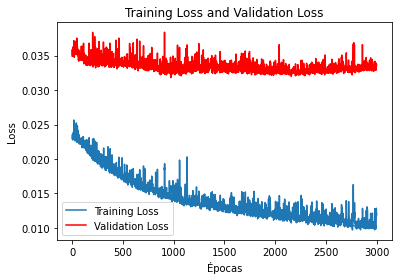

In [15]:
plt.figure()
plt.title("Training Loss and Validation Loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], 'r', label="Validation Loss")
plt.xlabel("Épocas", rotation=0)
plt.ylabel("Loss", rotation=90)
plt.legend()
plt.savefig('losssAutoencoder.png', format='png')

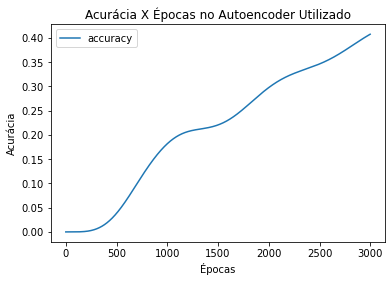

In [16]:
from scipy.signal import lfilter, butter, freqz

#faz um gráfico da acurácia de acordo com a quantidade de épocas
# o filtro passa-baixas suaviza o gráfico
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

plt.figure()
plt.title("Acurácia X Épocas no Autoencoder Utilizado")
plt.plot(butter_lowpass_filter(history.history["accuracy"], 0.01, 10), label="accuracy")
plt.xlabel("Épocas", rotation=0)
plt.ylabel("Acurácia", rotation=90)
plt.legend()
plt.savefig('acuAutoencoder.png', format='png')

C:\Users\luizf\AppData\Local\Temp\ipykernel_13068\1273145582.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


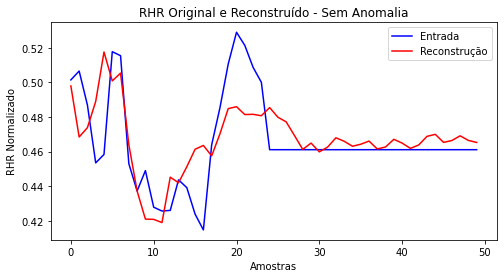

In [17]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.figure(figsize=(8,4))
plt.title("RHR Original e Reconstruído - Sem Anomalia")
plt.plot(normal_test_data[5], 'b')
plt.plot(decoded_data[5], 'r')
#plt.fill_between(normal_test_data[9],decoded_data[9], color='lightcoral')
plt.xlabel("Amostras", rotation=0)
plt.ylabel("RHR Normalizado", rotation=90)
plt.legend(labels=["Entrada", "Reconstrução", "Erro"])
#plt.fill_between(normal_test_data[9],decoded_data[9], color='lightcoral')
plt.show()
plt.savefig('recNormalAuto1.png', format='png')

C:\Users\luizf\AppData\Local\Temp\ipykernel_13068\2364561220.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


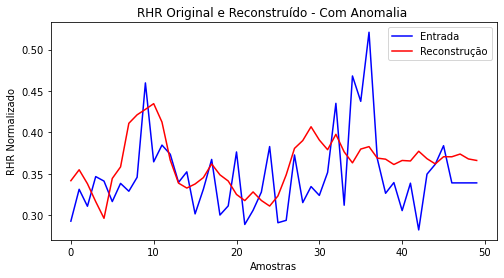

In [18]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.figure(figsize=(8,4))
plt.title("RHR Original e Reconstruído - Com Anomalia ")
plt.plot(anomalous_test_data[6], 'b')
plt.plot(decoded_data[6], 'r')
#plt.fill_between(normal_test_data[9],decoded_data[9], color='lightcoral')
plt.xlabel("Amostras", rotation=0)
plt.ylabel("RHR Normalizado", rotation=90)
plt.legend(labels=["Entrada", "Reconstrução", "Erro"])
plt.show()
plt.savefig('recAnolAuto1.png', format='png')

C:\Users\luizf\AppData\Local\Temp\ipykernel_4976\3854362438.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


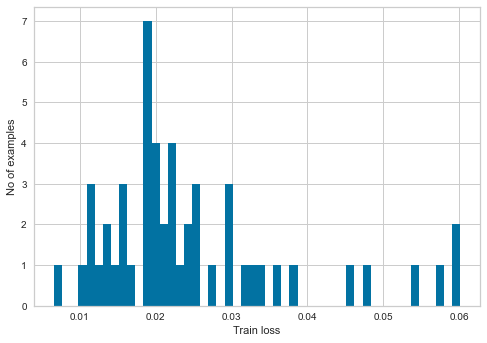

In [901]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

C:\Users\luizf\AppData\Local\Temp\ipykernel_4976\3067094974.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


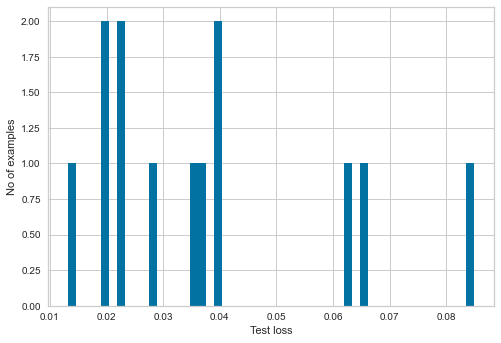

In [902]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [903]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [904]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Threshold:  0.037626944
Accuracy = 0.5517241379310345
Precision = 0.5
Recall = 0.6153846153846154


In [905]:
print(len(train_labels))
print(len(test_labels))
print(len(train_data))
print(len(test_data))

84
29
84
29


In [906]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_labels,preds)
print(cm)

[[8 8]
 [5 8]]
